In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

### Предопределенные константы

In [3]:
c = 3e10

In [20]:
h = 1e-2

### Базовые функции

In [6]:
def t(z):
    return (t_w - t_0)*z**p + t_0

def k(z):
    return k_0 * (t(z) / 300)**2

def u_p(z):    
    return 3.084e-4 / (np.exp(4.709e4 / t(z)) - 1)

In [7]:
def kappa(z):
    return c * (k(z + h/2) + k(z - h/2)) / 6 / r / k(z + h/2) / k(z - h/2)

In [8]:
def graph(x, y, title, color):
    plt.plot(x, y, color=color)
    plt.title(title)
    plt.grid()

In [9]:
def solve():
    zh = np.linspace(h/2, 1, int(2 / h + 1))
    
    M0 = kappa(zh[0]) * zh[0] + c * r * h * h / 8 * k(zh[0]) * zh[0]
    K0 = -kappa(zh[0]) * zh[0] + c * r * h * h / 8 * k(zh[0]) * zh[0]
    P0 = c * r * h * h / 4 * k(zh[0]) * u_p(zh[0]) * zh[0]
    xi = np.zeros((int(1 / h) + 1,))
    xi[0] = -K0 / M0
    etha = np.zeros((int(1 / h) + 1,))
    etha[0] = P0 / M0
    for i in range(int(1 / h)):
        z = zh[2*i]
        a_n = kappa(z) * z
        
        z = zh[2*i + 1]
        b_n = a_n + c * k(z) * z * h * h * r
        f_n = c * k(z) * u_p(z) * h * h * z * r
        
        z = zh[2*i + 2]
        c_n = kappa(z) * z
        b_n += c_n
        xi[i+1] = c_n / (b_n - a_n * xi[i])
        etha[i+1] = (f_n + a_n * etha[i])/(b_n - a_n * xi[i])

    y = np.zeros(xi.shape)
    z = zh[-2]
    MN = -kappa(z) * z + r * c * h * h / 8 * k(z) * z
    KN = kappa(z) * z + m * c * h / 2 + r * c * h * h / 8 * k(z) * z + r * c * h * h / 4 * k(1)
    PN = c * r * h * h / 4 * (k(z) * u_p(z) * z + k(1) * u_p(1))
    
    y[-1] = (PN - MN * etha[-1]) / (MN * xi[-1] + KN)
    for i in range(len(y) - 2, -1, -1):
        y[i] = y[i+1] * xi[i+1] + etha[i+1]

    return y, np.linspace(0, 1, y.shape[0])

In [10]:
def get_f_derivatives(y, z):
    dy = np.zeros(y.shape)
    dy[0] = (-3 * y[0] + 4 * y[1] - y[2]) / 2 / h
    for i in range(1, len(y) - 1):
        dy[i] = (y[i+1] - y[i-1]) / 2 / h
    dy[-1] = (3 * y[-1] - 4 * y[-2] + y[-3]) / 2 / h
    
    f = [-c / 3 / r / k(z[i]) * dy[i] for i in range(len(z))]
    f[0] = 0

    return f

In [11]:
def get_f_integrals(u, z):
    f = np.zeros(z.shape)
    zs = np.linspace(0, 1, f.shape[0])

    s = 0
    for i in range(1, len(f)):        
        s += h / 2 * (k(zs[i - 1]) * (u_p(zs[i - 1]) - u[i - 1]) * zs[i - 1] + k(zs[i]) * (u_p(zs[i]) - u[i]) * zs[i])
        f[i] = c * r / zs[i] * s

    return f

In [18]:
def get_div(u, z):
    return c * k(z) * (u_p(z) - u)

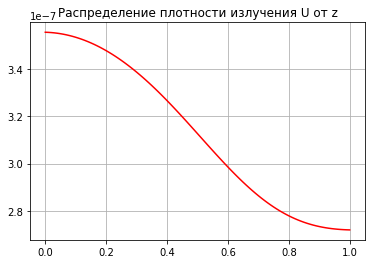

In [21]:
u, z = solve()
graph(z, u, "Распределение плотности излучения U от z", 'r')

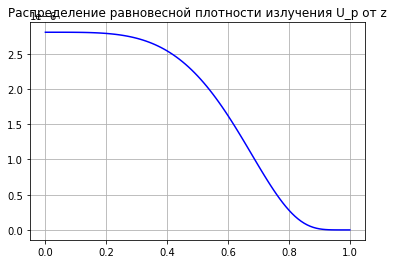

In [22]:
graph(z, u_p(z), "Распределение равновесной плотности излучения U_p от z", 'b')

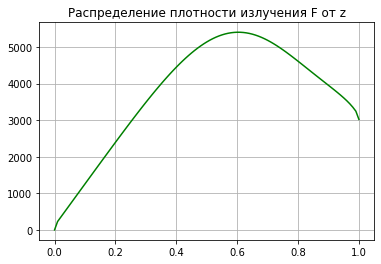

In [23]:
graph(z, get_f_derivatives(u, z), "Распределение плотности излучения F от z", 'g')

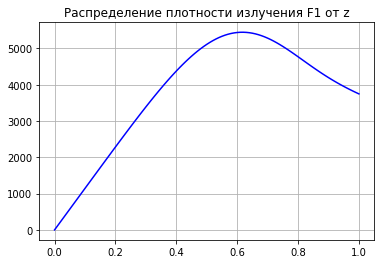

In [24]:
graph(z, get_f_integrals(u, z), "Распределение плотности излучения F1 от z", 'b')

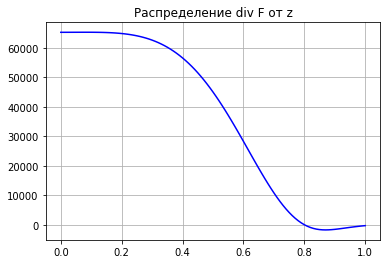

In [25]:
graph(z, get_div(u, z), "Распределение div F от z", 'b')

In [26]:
df = pd.DataFrame({'U': u[::10],
                   'U_p': u_p(z)[::10],
                   'F': get_f_derivatives(u, z)[::10],
                   'F1': get_f_integrals(u, z)[::10],
                   'dF': get_div(u, z)[::10]})

df

,U,U_p,F,F1,dF
0,3.557130e-07,2.805137e-06,0.000000,0.000000,65317.968484
1,3.535784e-07,2.804071e-06,1257.729889,1143.362431,65336.002800
2,3.478993e-07,2.788105e-06,2394.200919,2282.603834,64905.687588
3,3.387943e-07,2.719543e-06,3487.363524,3386.563580,62666.512657
4,3.267106e-07,2.539947e-06,4449.575418,4374.374321,56626.937851
5,3.127002e-07,2.184999e-06,5139.965601,5109.624877,45059.998280
6,2.985375e-07,1.620825e-06,5406.138583,5437.035794,28328.324014
7,2.863690e-07,9.100979e-07,5185.672809,5281.942629,10856.787603
8,2.778314e-07,2.803269e-07,4613.866362,4769.659776,30.079863
9,2.732755e-07,1.530259e-08,3954.566927,4195.200578,-1552.921472
